# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 22})
states = ("solid", "liquid", "gas")

The objective of the exercise is to study an **NVT** thermodynamic system, which means a system in which the number of particles (N), the volume (V), and the temperature (T) are fixed and constant throughout a simulation.

We are going to do it using the **Metropolis algorithm**, where each step is accepted with a probability $P = \mathrm{min}(1,exp(-\beta \Delta E))$. We use the block method for the average statistics with $M=5\times 10^5$ steps and the Metropolis acceptance ratio has been fixed approximately to 50%.


We have provided the **tail corrections** for potential energy, $U$, and pressure $P$ due to the cutoff.

We want to investigate the following thermodynamics systems:

- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

#### Exercise 7.1: Equilibration

We equilibrate the solid system starting from the perfectly crystalling structure, and the others from the final configuration of the previous phase.

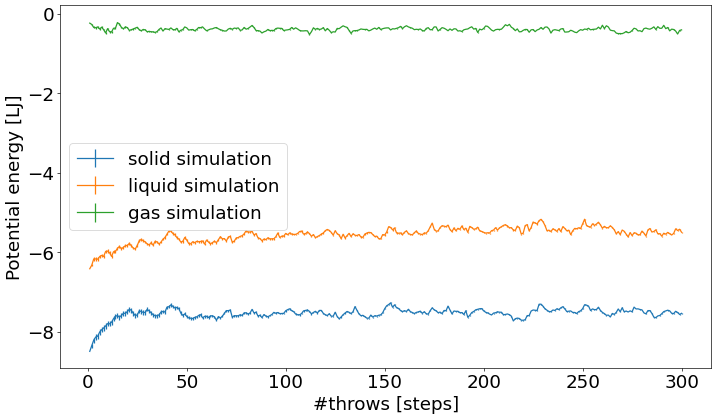

In [98]:
figure(figsize=(14, 8), dpi=60)
for state in states:
    #plt.title(f'{labels[count]}')
    x_eq,s_eq,err_eq = np.loadtxt(f"./data/equilibration/output_pot_{state}.dat", usecols=(0,1,2), unpack='true')       
    plt.errorbar(x_eq[:300],s_eq[:300],yerr = err_eq[:300],label=f"{state} simulation")
    plt.xlabel("#throws [steps]")
    plt.ylabel("Potential energy [LJ]")
plt.legend()

The equilibration is reached after at most 100 steps

#### Exercise 7.2: autocorrelation

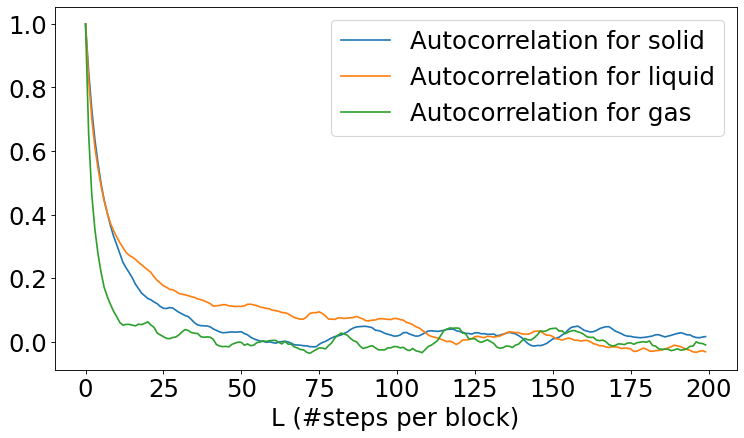

In [99]:
xs = []
for state in states:
    xs.append(np.loadtxt(f"./data/equilibration/output_pot_{state}.dat", usecols=(1), unpack='true'))
def AutoCorr(t, state,x):
    a1=0
    a2=0
    a3=0
    v1=0
    v2=0
    x=x[:10000]
    tmax=len(x)
    for i in range(tmax-t):
        a1+=x[i]*x[i+t]
        a2+=x[i]
        a3+=x[i+t]
    for i in range(tmax):
        v1+=x[i]*x[i]
        v2+=x[i] 
    var = (v1/tmax)-(v2/tmax)**2
    return (a1/(tmax-t) - a2*a3/((tmax-t)*(tmax-t)))/var  

figure(figsize=(11, 6), dpi=80)
for i in range(3):
    a = [AutoCorr(t,states[i],xs[i]) for t in range(200)]
    plt.plot(a,label="Autocorrelation for "+states[i])
    plt.xlabel("L (#steps per block)")
plt.legend()

##### OBSERVATION
From an observational criteria we can say that after 100 steps the trends behave in an uncorrelate way.


##### STEP 3: Test the block lengh
In order to discover which is the best length for block statistic I also compute uncertainties of the Potential Energy along the block length **L**: from $L=M/N=10$ to $L=5\times 10^3$

In [101]:
M=50000
def error(AV,AV2,n):
    if (n==0): err=0
    else: err = np.sqrt((AV2 - AV*AV)/n)
    return err

def Average(L,vec):
    N=int(M/L)
    cum_ave = 0
    cum_av2 = 0
    for i in range(N):
        sum_ave = 0
        for j in range(L):
            sum_ave += vec[j+i*L]
        sum_ave /= L
        cum_ave += sum_ave
        cum_av2 += sum_ave*sum_ave
    cum_ave = cum_ave/N
    cum_av2 = cum_av2/N
    return error(cum_ave,cum_av2,N)

In [102]:
nstep = 10
errs=[]
for i in range(3):
    print('----------------------')
    print(states[i]+" compiling...   ")
    err = []
    x = np.loadtxt(f"./data/equilibration/output_pot_{states[i]}.dat", usecols=(1), unpack='true')
    for L in range(10,5000,nstep):
        err.append(Average(L,x))
    errs.append(err)
    print("Done!\n")


----------------------
solid compiling...   
Done!

----------------------
liquid compiling...   
Done!

----------------------
gas compiling...   
Done!



(10, 5000)

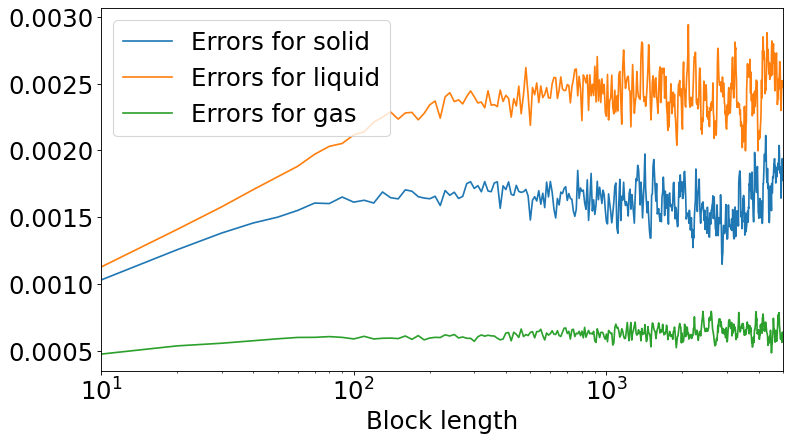

In [104]:

figure(figsize=(11, 6), dpi=80)
for i in range(3):
    plt.plot(np.arange(10,5000,10),errs[i],label="Errors for "+states[i])
    plt.xlabel("Block length")
plt.legend()
plt.xscale('log')
plt.xlim(10,5000)

#### Observation
In the plot above, in log scale, shows the exponential behaviour of the errors for all the thermodynamics environments. The error flatted after blocks with the lengh of 1000 steps and oscillate around a plateau value.

### Exercise 07.3

We choose to study the radial distribution function G(r).
This function represents, for a particle, the probability of meet another particle at a distance r compared to the case of an ideal gas. In practice, we create a histogram (we choose 100 bins), and for each particle pair, we add 2 (since the distance is reciprocal) to the corresponding bin: 
$$ \mathrm{bin} = \mathrm{nbins} \cdot \frac{\mathrm{dr}}{0.5\cdot L}$$
where nbins = 100 is the number of bins, dr is the distance between the two particles and L is the side of the box choosen in the algorithm for periodic boundary conditions.
Hence we consider 108 particles:
$$ V = \frac{108  \, \mathrm{particles}}{\rho} \\  \\  L= V^{\frac{1}{3}}$$

We want to investigate the Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu):

In [7]:
npart=108
rho=[1.1,0.8,0.05]
def plot_g(L,ex,t):
    states =("solid", "liquid", "gas")
    col=("blue", "green", "orange")
    m =("o",'d','x')
    figure(figsize=(15, 6), dpi=80)

    for i in range(3):
        #print(f"\nCompute g(r) function for {states[i]} simulation\n")
        g = np.loadtxt(f"./data/{ex}/output_g_{states[i]}_{t}.dat", unpack='true')
        g_err = np.loadtxt(f"./data/{ex}/output_g_err_{states[i]}_{t}.dat", unpack='true')
        L = (npart/rho[i])**(1/3)
        n = 1/100*L/2
        plt.errorbar(np.arange(len(g[1:,0]))*n,g[1:,0],yerr = g_err[1:,0],label=states[i]+" g(r)",color=col[i],linewidth=2, marker=m[i] ,markersize=7)
        plt.legend()
        plt.xlabel("r")
        plt.ylabel("g(r)")
        plt.xlim([0, 3])
    plt.grid()

Below we show the **potential energy**, $U$, and **pressure**, $P$ for the solid , liquid and gas thermodynamic systems of the Argon.

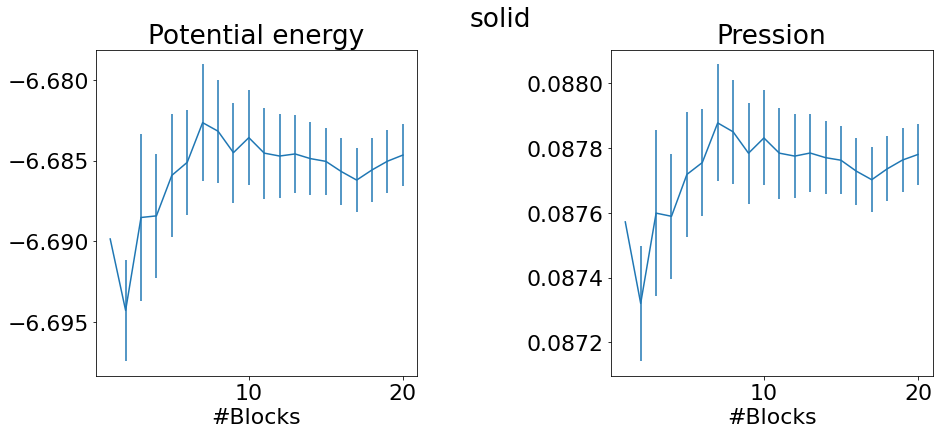

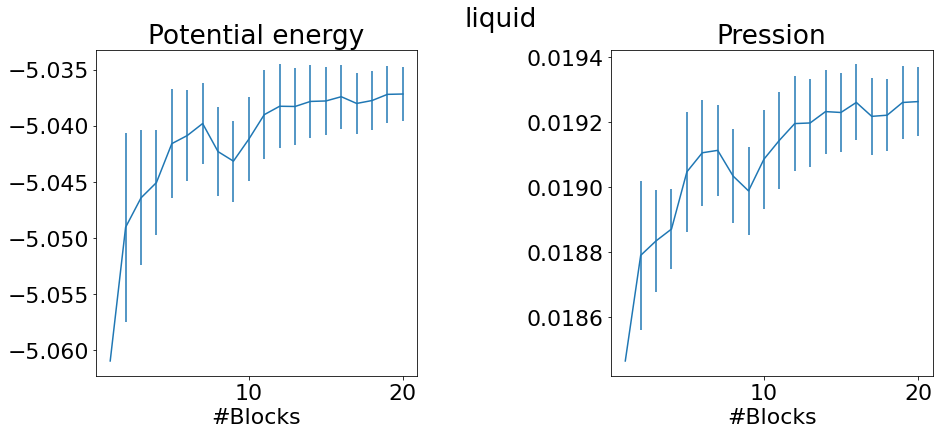

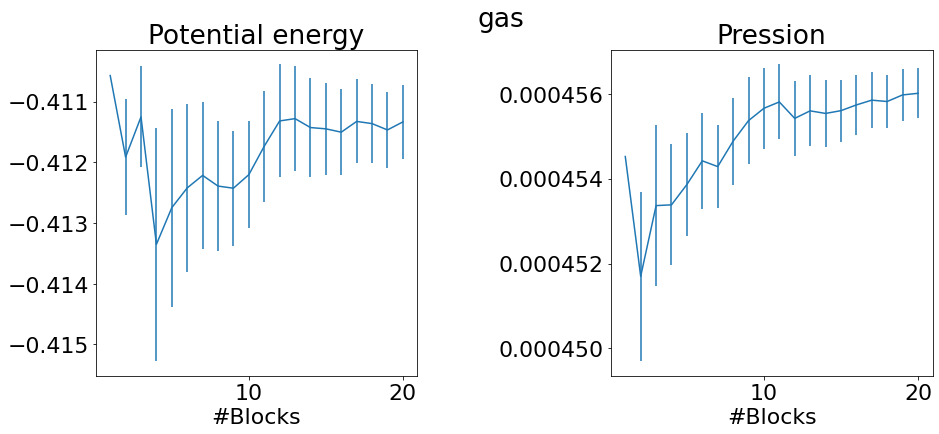

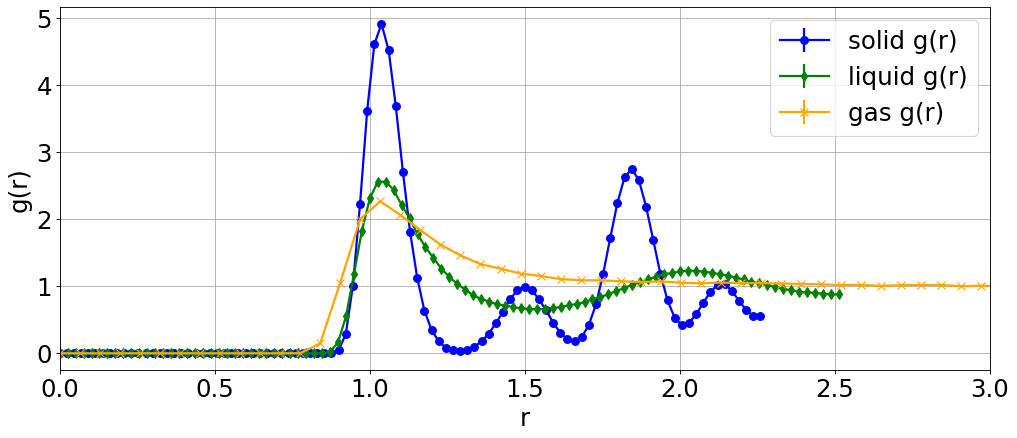

In [11]:
file_name =["epot","pres"]

for state in states:
    fig, axs = plt.subplots(1, 2,figsize=(15,6))
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    for i in range(2):
        x,s,err = np.loadtxt(f"./data/NVT/output_{file_name[i]}_{state}_1.dat", usecols=(0,2,3), unpack='true')
        axs[i].errorbar(x,s,yerr=err)
        axs[i].set_xlabel('#Blocks')
    axs[0].set_title("Potential energy")
    axs[1].set_title("Pression")
    fig.suptitle(state)


plot_g(2000,"NVT",1)

plt.show()

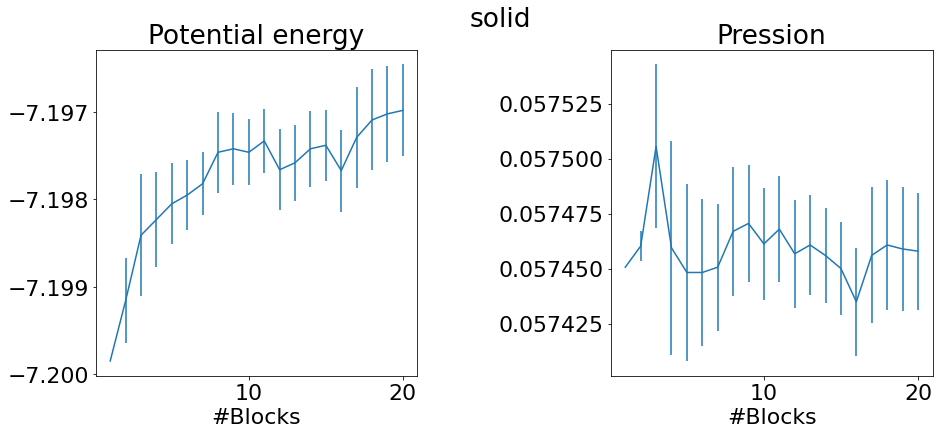

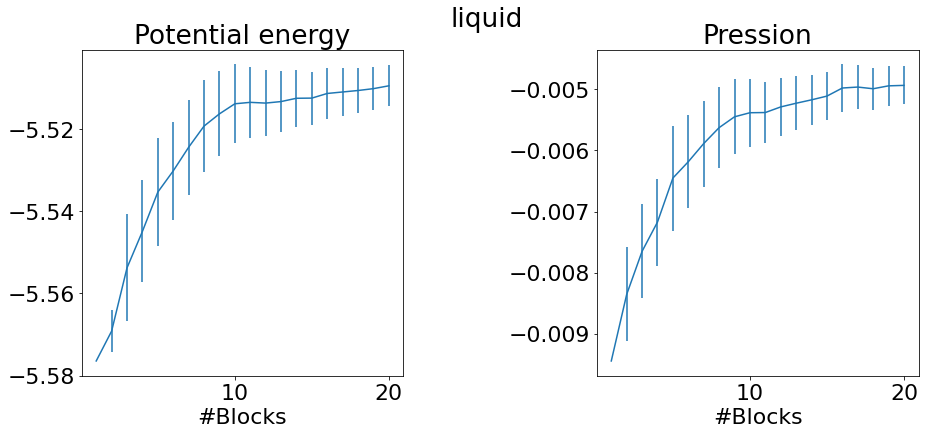

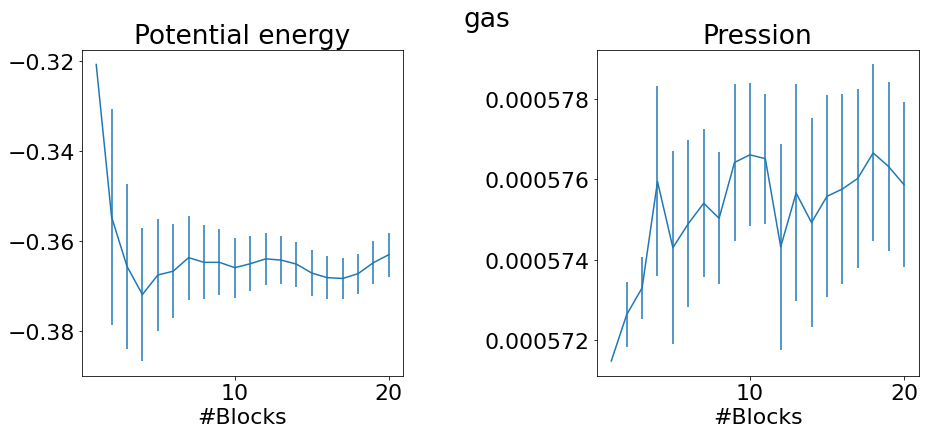

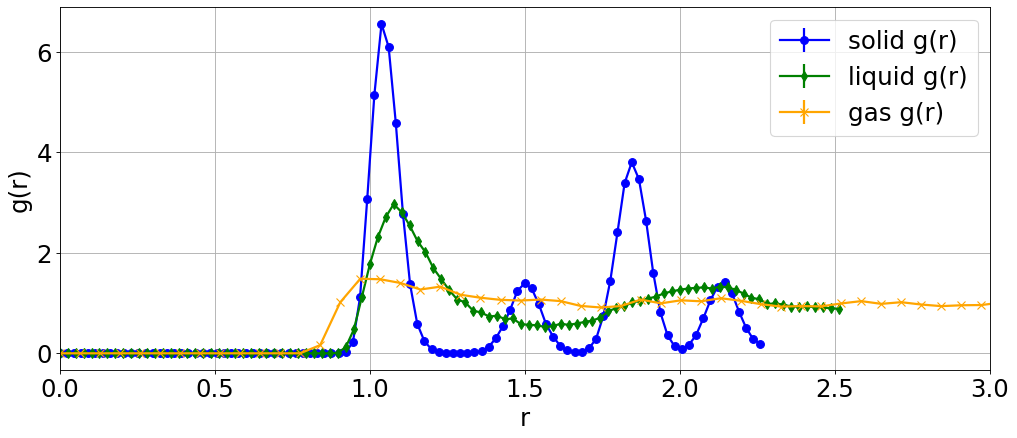

In [15]:
file_name =["epot","pres"]

for state in states:
    fig, axs = plt.subplots(1, 2,figsize=(15,6))
    plt.subplots_adjust(wspace=0.6, hspace=0.5)
    for i in range(2):
        x,s,err = np.loadtxt(f"./data/NVE/output_{file_name[i]}_{state}_0.dat", usecols=(0,2,3), unpack='true')
        axs[i].errorbar(x,s,yerr=err)
        axs[i].set_xlabel('#Blocks')
    axs[0].set_title("Potential energy")
    axs[1].set_title("Pression")
    fig.suptitle(state)

plot_g(2000,"NVE",0)

plt.show()

We can do fews **observations**:

- As expected, in the solid state, G(r) is a periodic function due to its crystalline nature, while in contrast, in the gas state, there is an absence of periodicity after an initial peak.

- For all states, particles are not found at distances below a minimum distance, highlighting the divergent nature of the LJ potential

- Once a minimum threshold is exceeded, the gas behaves like an ideal gas:$$ g(r) \to 1 \: \mathrm{for} \: r>>1$$

### Exercise 07.4
#### Match G(r) for MC and MD modes
Furthermore, we compare the radial distribution functions (G(r)) obtained for each state in both MC and MD modes. These two modes represent different thermodynamic systems (NVE/NVT), but for an infinite number of particles, we expect them to be analogous. Therefore, we anticipate overlapping behavior, although not necessarily identical.

In [18]:
npart=108
rho=[1.1,0.8,0.05]
th_state=["NVE","NVT"]
def plot_g_match(L,ex,i):
    col=("blue","red")
    m =("o","D")
    alg = ("MD","MC")
    figure(figsize=(15, 6), dpi=80)
    for t in range(2):
        #print(f"\nCompute g(r) function for {states[i]} simulation\n")
        g = np.loadtxt(f"./data/{th_state[t]}/output_g_{states[i]}_{t}.dat", unpack='true')
        g_err = np.loadtxt(f"./data/{th_state[t]}/output_g_err_{states[i]}_{t}.dat", unpack='true')
        L = (npart/rho[i])**(1/3)
        n = 1/100*L/2
        plt.errorbar(np.arange(len(g[1:,0]))*n,g[1:,0],yerr = g_err[1:,0],label="g(r) "+alg[t],color=col[t],linewidth=2, marker=m[t] ,markersize=7)
    plt.ylabel("<g(r)> "+states[i])
    plt.legend()
    plt.xlim([0, 3])
    plt.grid()

[None, None, None]

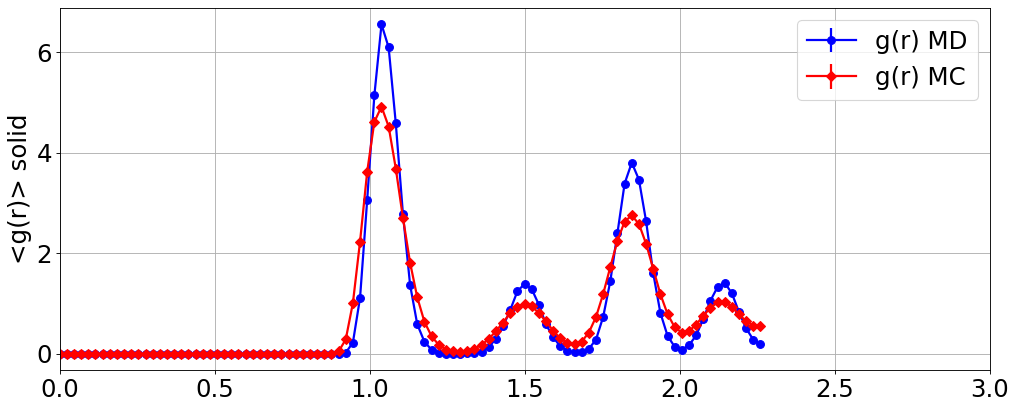

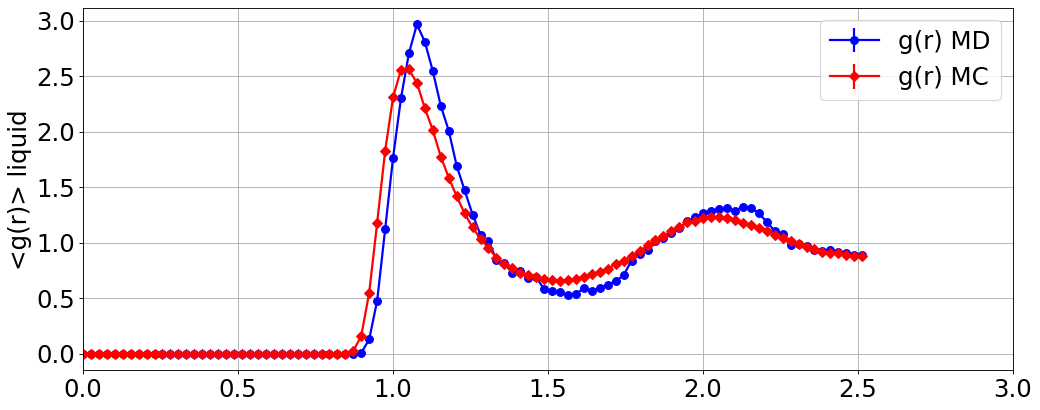

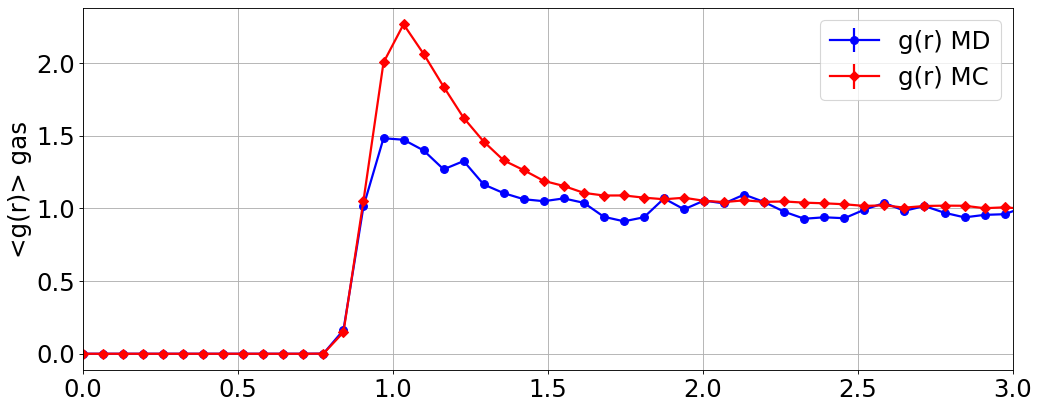

In [19]:
[plot_g_match(2000,"ex4",i) for i in range(3)]